In [1]:
import random 
import numpy as np 
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from surprise import Dataset, Reader, NormalPredictor
from surprise.model_selection import train_test_split

from utils.modelos import *
from utils.transformacion import *
from utils.recomendaciones import *



VAR_SEED = 42
VAR_TESTSET_SIZE = 0.20
VAR_DIR_DATA_CLEANING = '../data/cleaning'
random.seed(VAR_SEED)
np.random.seed(VAR_SEED)



DATASET = pd.read_csv(f"{VAR_DIR_DATA_CLEANING}/dataset.csv", encoding="latin1")
columnas = ['ejercicios_hito1', 'ejercicios_hito2', 'ejercicios_hito3', 'ejercicios_hito4']
DATASET[columnas] = DATASET[columnas].apply(lambda col: col.replace('-1', -1))

CATALOGO = pd.read_csv(f"{VAR_DIR_DATA_CLEANING}/catalogo.csv", encoding="latin1")
PRUEBA_DIAGNOSTICO = pd.read_csv(f"{VAR_DIR_DATA_CLEANING}/prueba_diagnostico.csv", encoding="latin1")
MATRIX_FACTORIZACION = pd.read_csv(f"{VAR_DIR_DATA_CLEANING}/matrix_factorization.csv", encoding="latin1")

2024-11-17 12:38:37.237721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731857917.258188  159063 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731857917.264536  159063 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 12:38:37.287532: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dataset, test_dataset, train_matrix, test_matrix, train_prueba, test_prueba = crear_train_test_con_queries(
    dataset=DATASET, 
    matrix=MATRIX_FACTORIZACION,
    prueba=PRUEBA_DIAGNOSTICO
)

df_catalogo = CATALOGO.copy()
df_catalogo.head()

,id_ejercicio,nombre,h1,h2,h3,h4,s1,s2,s3,s4,...,complexity,complexity12,puntos,enunciado,dificultad,score_a,score_d,score_p,score_s,ratio_interaccion
0,0,CÃ¡lculo del dÃ­gito verificador del rut,0,0,0,1,0,0,0,1,...,23,279,2.0,escribe un programa que reciba como dato un nÃ...,2.25,10.0,0.0,4.0,2.0,0.589094
1,1,Calculadora GeomÃ©trica,0,0,1,0,0,0,0,1,...,17,529,2.0,construye un programa que permita calcular el ...,2.50,8.0,7.0,2.0,0.0,0.213518
2,2,Subsecuencias de ADN,0,0,1,0,0,0,1,1,...,55,567,5.0,escribe un programa que reciba como entrada un...,5.00,12.0,7.0,8.0,3.0,0.013057
3,3,NÃºmeros Primos,0,0,0,1,0,0,0,0,...,3,259,2.0,escribe una funciÃ³n llamada es_primo que reto...,1.50,7.0,2.0,2.0,0.0,0.492320
4,4,Nota Final,0,0,0,1,0,0,0,0,...,1,257,1.0,realiza un programa para preguntar al usuario ...,1.25,8.0,1.0,2.0,0.0,0.781874


In [3]:
formula_1 = {"hito": (1, 4), "skill": (0, 15), "knowledge": (1, 15), "ratio_interaccion": (0, 1)}
pesos_1 = {"hito": 0.4, "skill": 0.25, "knowledge": 0.25, "ratio_interaccion": 0.1}


formula_2 = {
    "hito": (df_catalogo['hito'].min(), df_catalogo['hito'].max()), 
    "skill": (df_catalogo['skill'].min(), df_catalogo['skill'].max()), 
    "knowledge": (df_catalogo['knowledge'].min(), df_catalogo['knowledge'].max()),
    "puntos": (df_catalogo['puntos'].min(), df_catalogo['puntos'].max()),
    "dificultad": (df_catalogo['dificultad'].min(), df_catalogo['dificultad'].max())
}
pesos_2 = {"hito": 0.3, "skill": 0.15, "knowledge": 0.15, "puntos": 0.2, "dificultad": 0.2}


formula_3 = {
    "hito": (df_catalogo['hito'].min(), df_catalogo['hito'].max()), 
    "skill": (df_catalogo['skill'].min(), df_catalogo['skill'].max()), 
    "knowledge": (df_catalogo['knowledge'].min(), df_catalogo['knowledge'].max()),
    "puntos": (df_catalogo['puntos'].min(), df_catalogo['puntos'].max()),
    "dificultad": (df_catalogo['dificultad'].min(), df_catalogo['dificultad'].max()),
    "score_a": (df_catalogo['score_a'].min(), df_catalogo['score_a'].max()),
    "score_d": (df_catalogo['score_d'].min(), df_catalogo['score_d'].max()),
    "score_p": (df_catalogo['score_p'].min(), df_catalogo['score_p'].max()),
    "score_s": (df_catalogo['score_s'].min(), df_catalogo['score_s'].max())
}
pesos_3 = {"hito": 0.2, "skill": 0.15, "knowledge": 0.15, "puntos": 0.1, "dificultad": 0.2, "score_a": 0.05, "score_d": 0.05, "score_p": 0.05, "score_s": 0.05}


formula_4 = {
    "complexity12": (df_catalogo['complexity12'].min(), df_catalogo['complexity12'].max()),
    "puntos": (df_catalogo['puntos'].min(), df_catalogo['puntos'].max()),
    "dificultad": (df_catalogo['dificultad'].min(), df_catalogo['dificultad'].max()),
    "score_a": (df_catalogo['score_a'].min(), df_catalogo['score_a'].max()),
    "score_d": (df_catalogo['score_d'].min(), df_catalogo['score_d'].max()),
    "score_p": (df_catalogo['score_p'].min(), df_catalogo['score_p'].max()),
    "score_s": (df_catalogo['score_s'].min(), df_catalogo['score_s'].max())
}
pesos_4 = {"complexity12": 0.4, "puntos": 0.15, "dificultad": 0.25, "score_a": 0.05, "score_d": 0.05, "score_p": 0.05, "score_s": 0.05}

In [4]:
df_catalogo = calcular_puntuacion_dataset(
    dataframe=df_catalogo, 
    caracteristicas=formula_1, 
    pesos=pesos_1, 
    nueva_columna='puntuacion_1'
)

df_catalogo = calcular_puntuacion_dataset(
    dataframe=df_catalogo, 
    caracteristicas=formula_2, 
    pesos=pesos_2, 
    nueva_columna='puntuacion_2'
)

df_catalogo = calcular_puntuacion_dataset(
    dataframe=df_catalogo, 
    caracteristicas=formula_3, 
    pesos=pesos_3, 
    nueva_columna='puntuacion_3'
)

df_catalogo = calcular_puntuacion_dataset(
    dataframe=df_catalogo, 
    caracteristicas=formula_4, 
    pesos=pesos_4, 
    nueva_columna='puntuacion_4'
)


In [5]:

df_catalogo = df_catalogo[['id_ejercicio', 'complexity', 'complexity12', 'puntuacion_1', 'puntuacion_2', 'puntuacion_3', 'puntuacion_4']]

df_ratings = factorizacion_a_calificaciones(
    df_ejercicios=df_catalogo,
    matriz_factorizacion=train_matrix, 
    columna_usuario='id_estudiante'
)

In [6]:
df_ratings

,id_estudiante,id_ejercicio,complexity,complexity12,puntuacion_1,puntuacion_2,puntuacion_3,puntuacion_4
0,0,0.0,23.0,279.0,0.182719,0.174588,0.224198,0.180973
1,0,1.0,17.0,529.0,0.171352,0.217995,0.234961,0.294797
2,0,3.0,3.0,259.0,0.084946,0.096154,0.123651,0.121732
3,0,4.0,1.0,257.0,0.078187,0.038462,0.079970,0.089585
4,0,6.0,19.0,531.0,0.207450,0.270192,0.331150,0.378078
...,...,...,...,...,...,...,...,...
6403,466,28.0,39.0,551.0,0.286943,0.331044,0.365932,0.367159
6404,466,29.0,3.0,259.0,0.101152,0.142308,0.192483,0.202102
6405,466,37.0,39.0,551.0,0.288172,0.338736,0.378595,0.381744
6406,466,42.0,3.0,259.0,0.077419,0.163187,0.195779,0.210618


In [7]:
# ESCALAS DE RANKING 
escala_01 = Reader(rating_scale=(0, 1))
escala_02 = Reader(rating_scale=(1, 255))
escala_03 = Reader(rating_scale=(257, 1279))

# CARGA DE DATOS
data_formula1 = Dataset.load_from_df(df_ratings[["id_estudiante", "id_ejercicio", "puntuacion_1"]], escala_01)
data_formula2 = Dataset.load_from_df(df_ratings[["id_estudiante", "id_ejercicio", "puntuacion_2"]], escala_01)
data_formula3 = Dataset.load_from_df(df_ratings[["id_estudiante", "id_ejercicio", "puntuacion_3"]], escala_01)
data_formula4 = Dataset.load_from_df(df_ratings[["id_estudiante", "id_ejercicio", "puntuacion_4"]], escala_01)
data_complexity = Dataset.load_from_df(df_ratings[["id_estudiante", "id_ejercicio", "complexity"]], escala_02)
data_complexity12 = Dataset.load_from_df(df_ratings[["id_estudiante", "id_ejercicio", "complexity12"]], escala_03)

In [8]:
# MODELOS
benchmark_formula1 = evaluar_algoritmos(data_formula1)
benchmark_formula2 = evaluar_algoritmos(data_formula2)
benchmark_formula3 = evaluar_algoritmos(data_formula3)
benchmark_formula4 = evaluar_algoritmos(data_formula4)
benchmark_complexity = evaluar_algoritmos(data_complexity)
benchmark_complexity12 = evaluar_algoritmos(data_complexity12)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

In [9]:
benchmark_formula1

,test_rmse,test_mae,fit_time,test_time
Algoritmo,,,,
KNNBasic,0.001248,0.000038,0.027922,0.162705
KNNBaseline,0.002289,0.001509,0.031453,0.179399
BaselineOnly,0.011010,0.004556,0.005246,0.003039
SVDpp,0.019237,0.014030,0.164234,0.035695
KNNWithMeans,0.024584,0.019404,0.030567,0.178478
KNNWithZScore,0.030318,0.019686,0.049011,0.174047
SVD,0.053115,0.041506,0.053956,0.005993
NMF,0.063610,0.055261,0.074973,0.004958
SlopeOne,0.071009,0.057322,0.006669,0.012342


In [10]:
benchmark_formula2

,test_rmse,test_mae,fit_time,test_time
Algoritmo,,,,
KNNBasic,0.003081,0.000137,0.025975,0.168229
KNNBaseline,0.003891,0.002414,0.034631,0.187028
BaselineOnly,0.019025,0.006503,0.004655,0.003122
SVDpp,0.022481,0.014947,0.144344,0.032216
KNNWithMeans,0.032595,0.025085,0.031369,0.192616
KNNWithZScore,0.040042,0.028104,0.048485,0.181177
SVD,0.054839,0.041708,0.052231,0.006813
NMF,0.065462,0.055083,0.078714,0.005544
SlopeOne,0.095512,0.074471,0.006449,0.015546


In [11]:
benchmark_formula3

,test_rmse,test_mae,fit_time,test_time
Algoritmo,,,,
KNNBasic,0.002882,0.000138,0.026004,0.164811
KNNBaseline,0.003822,0.002327,0.034088,0.190146
BaselineOnly,0.018681,0.006224,0.005338,0.002982
SVDpp,0.022536,0.015224,0.144113,0.031111
KNNWithMeans,0.031367,0.023894,0.038107,0.169026
KNNWithZScore,0.038667,0.026800,0.049921,0.186526
SVD,0.055250,0.042181,0.051762,0.006898
NMF,0.063945,0.057152,0.074453,0.005220
SlopeOne,0.092894,0.071934,0.006693,0.013354


In [12]:
benchmark_formula4

,test_rmse,test_mae,fit_time,test_time
Algoritmo,,,,
KNNBasic,0.001875,0.000060,0.026453,0.153022
KNNBaseline,0.003961,0.002426,0.031171,0.181070
BaselineOnly,0.020168,0.006620,0.005646,0.003969
SVDpp,0.022112,0.014895,0.144657,0.035166
KNNWithMeans,0.034171,0.026202,0.030276,0.219439
KNNWithZScore,0.039701,0.027977,0.049258,0.176831
SVD,0.056042,0.042766,0.055835,0.006443
NMF,0.064503,0.057091,0.079409,0.005429
SlopeOne,0.101225,0.079658,0.006684,0.013225


In [13]:
benchmark_complexity

,test_rmse,test_mae,fit_time,test_time
Algoritmo,,,,
KNNBasic,0.275820,0.008594,0.026710,0.166497
SlopeOne,0.409488,0.027072,0.006719,0.013186
KNNBaseline,0.553459,0.321070,0.033647,0.193883
SVDpp,1.026211,0.751199,0.144891,0.031684
SVD,1.935927,0.527835,0.050883,0.005652
BaselineOnly,2.804122,0.909503,0.005519,0.004291
CoClustering,3.682894,2.550163,0.072128,0.005252
KNNWithMeans,4.086672,2.957022,0.031275,0.170938
KNNWithZScore,5.845014,3.565941,0.049234,0.193537


In [14]:
benchmark_complexity12

,test_rmse,test_mae,fit_time,test_time
Algoritmo,,,,
KNNBasic,1.973837,0.064295,0.025719,0.158620
SlopeOne,2.746852,0.162068,0.007526,0.013186
KNNBaseline,3.270285,2.050886,0.031918,0.194840
BaselineOnly,16.218606,6.947846,0.004989,0.002974
CoClustering,29.509147,18.618157,0.096542,0.006068
KNNWithMeans,34.127629,23.029314,0.031592,0.439238
KNNWithZScore,47.365758,27.399900,0.047597,0.199917
NMF,137.830446,70.704522,0.076949,0.005566
NormalPredictor,151.006071,113.812551,0.004524,0.003578


In [15]:
import pandas as pd
from pandas import DataFrame
from surprise import SVD, Reader, Dataset, accuracy
from surprise.model_selection import cross_validate
from joblib import dump, load
from typing import Tuple, Optional

In [16]:
class SistemaRecomendadorSurprise:
    def __init__(self, algoritmo = SVD(), ruta_modelo: str = 'RecommenderSystemSurprise.joblib'):
        self.modelo = algoritmo
        self.ruta_modelo = ruta_modelo
        self.datos = None
        self.conjunto_entrenamiento = None

    def cargar_datos(self, dataframe: DataFrame, escala_valoraciones: Tuple[float, float]):
        lector = Reader(rating_scale=escala_valoraciones)
        self.datos = Dataset.load_from_df(dataframe, lector)

    def entrenar(self):
        if not self.datos:
            raise ValueError("No se han cargado datos. Usa 'cargar_datos' para cargar un DataFrame primero.")
        self.conjunto_entrenamiento = self.datos.build_full_trainset()
        self.modelo.fit(self.conjunto_entrenamiento)
        print("[+] Modelo entrenado.")

    def evaluar(self, cv: int = 5):
        if not self.datos:
            raise ValueError("No se han cargado datos. Usa 'cargar_datos' para cargar un DataFrame primero.")
        return cross_validate(self.modelo, self.datos, measures=['RMSE', 'MAE'], cv=cv, verbose=True)

    def predecir(self, id_usuario, id_item):
        if not self.conjunto_entrenamiento:
            raise ValueError("El modelo no está entrenado. Usa 'entrenar' para entrenar el modelo primero.")
        return self.modelo.predict(id_usuario, id_item).est

    def obtener_recomendaciones(self, id_usuario: int, columna_usuario: str = 'user_id', columna_item: str = 'item_id', n_recomendaciones: int = 10):
        if not self.conjunto_entrenamiento:
            raise ValueError("El modelo no está entrenado. Usa 'entrenar' para entrenar el modelo primero.")
        
        df = self.datos.df
        items_interactuados = df[df[columna_usuario] == id_usuario][columna_item].unique()
        todos_items = df[columna_item].unique()
        pares_items = [(id_usuario, item, 0) for item in set(todos_items) - set(items_interactuados)]
        
        recomendaciones = sorted(self.modelo.test(pares_items), key=lambda x: x.est, reverse=True)[:n_recomendaciones]
        return [int(pred.iid) for pred in recomendaciones]

    def guardar_modelo(self):
        dump(self.modelo, self.ruta_modelo)
        print(f"[+] Modelo guardado en {self.ruta_modelo}.")

    def cargar_modelo(self):
        self.modelo = load(self.ruta_modelo)
        print(f"[+] Modelo cargado desde {self.ruta_modelo}.")

    def actualizar_y_reentrenar(self, nuevo_dataframe: DataFrame, escala_valoraciones: Tuple[float, float]):
        if not self.datos:
            raise ValueError("No se han cargado datos. Usa 'cargar_datos' para cargar un DataFrame inicial primero.")
        
        df_actualizado = pd.concat([self.datos.df, nuevo_dataframe]).drop_duplicates()
        self.cargar_datos(df_actualizado, escala_valoraciones)
        self.entrenar()
        print("[+] Modelo actualizado y reentrenado con nuevos datos.")

    def evaluar_recomendaciones(self, n_recomendaciones: int = 10) -> Tuple[float, float, float]:
        if not self.conjunto_entrenamiento:
            raise ValueError("El modelo no está entrenado. Usa 'entrenar' para entrenar el modelo primero.")
        
        conjunto_prueba = self.conjunto_entrenamiento.build_anti_testset()
        predicciones = self.modelo.test(conjunto_prueba)
        
        usuario_estimaciones = {}
        for pred in predicciones:
            usuario_estimaciones.setdefault(pred.uid, []).append((pred.iid, pred.est, pred.r_ui))
        
        precisiones, coberturas, promedio_precisiones = [], [], []
        for valoraciones in usuario_estimaciones.values():
            valoraciones.sort(key=lambda x: x[1], reverse=True)
            items_relevantes = sum((1 for (_, _, r_real) in valoraciones if r_real > 0))
            if items_relevantes == 0:
                continue

            items_recomendados = valoraciones[:n_recomendaciones]
            relevantes_recomendados = sum((1 for (_, _, r_real) in items_recomendados if r_real > 0))
            
            precisiones.append(relevantes_recomendados / n_recomendaciones)
            coberturas.append(relevantes_recomendados / items_relevantes)
            
            hits, promedio_precision = 0, 0.0
            for i, (_, _, r_real) in enumerate(items_recomendados):
                if r_real > 0:
                    hits += 1
                    promedio_precision += hits / (i + 1)
            promedio_precisiones.append(promedio_precision / min(items_relevantes, n_recomendaciones))

        precision = sum(precisiones) / len(precisiones) if precisiones else 0
        cobertura = sum(coberturas) / len(coberturas) if coberturas else 0
        map_score = sum(promedio_precisiones) / len(promedio_precisiones) if promedio_precisiones else 0

        return precision, cobertura, map_score


In [17]:
df_ratings.head()

,id_estudiante,id_ejercicio,complexity,complexity12,puntuacion_1,puntuacion_2,puntuacion_3,puntuacion_4
0,0,0.0,23.0,279.0,0.182719,0.174588,0.224198,0.180973
1,0,1.0,17.0,529.0,0.171352,0.217995,0.234961,0.294797
2,0,3.0,3.0,259.0,0.084946,0.096154,0.123651,0.121732
3,0,4.0,1.0,257.0,0.078187,0.038462,0.079970,0.089585
4,0,6.0,19.0,531.0,0.207450,0.270192,0.331150,0.378078


In [18]:
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering 

# FORMULA 1

In [19]:
recommender1 = SistemaRecomendadorSurprise(algoritmo=KNNBasic(), ruta_modelo='dumps/RecommenderSystemSurprise.joblib')
recommender1.cargar_datos(dataframe=df_ratings[['id_estudiante', 'id_ejercicio', 'puntuacion_1']], escala_valoraciones=(0, 1))
recommender1.entrenar()
results1 = recommender1.evaluar()
metricas1 = recommender1.evaluar_recomendaciones()

Computing the msd similarity matrix...
Done computing similarity matrix.
[+] Modelo entrenado.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0018  0.0008  0.0000  0.0020  0.0000  0.0009  0.0009  
MAE (testset)     0.0001  0.0000  0.0000  0.0001  0.0000  0.0000  0.0000  
Fit time          0.03    0.03    0.03    0.03    0.03    0.03    0.00    
Test time         0.16    0.15    0.16    0.16    0.15    0.16    0.00    


# FORMULA 2

In [20]:
recommender2 = SistemaRecomendadorSurprise(algoritmo=KNNBasic(), ruta_modelo='dumps/RecommenderSystemSurprise.joblib')
recommender2.cargar_datos(dataframe=df_ratings[['id_estudiante', 'id_ejercicio', 'puntuacion_2']], escala_valoraciones=(0, 1))
recommender2.entrenar()
results2 = recommender2.evaluar()
metricas2 = recommender2.evaluar_recomendaciones()

Computing the msd similarity matrix...
Done computing similarity matrix.
[+] Modelo entrenado.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0030  0.0033  0.0000  0.0033  0.0017  0.0023  0.0013  
MAE (testset)     0.0001  0.0001  0.0000  0.0001  0.0000  0.0001  0.0000  
Fit time          0.03    0.02    0.03    0.03    0.03    0.03    0.00    
Test time         0.16    0.16    0.17    0.16    0.15    0.16    0.01    


# FORMULA 3

In [21]:
recommender3 = SistemaRecomendadorSurprise(algoritmo=KNNBasic(), ruta_modelo='dumps/RecommenderSystemSurprise.joblib')
recommender3.cargar_datos(dataframe=df_ratings[['id_estudiante', 'id_ejercicio', 'puntuacion_3']], escala_valoraciones=(0, 1))
recommender3.entrenar()
results3 = recommender3.evaluar()
metricas3 = recommender3.evaluar_recomendaciones()

Computing the msd similarity matrix...
Done computing similarity matrix.
[+] Modelo entrenado.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0031  0.0044  0.0025  0.0000  0.0024  0.0025  0.0014  
MAE (testset)     0.0001  0.0002  0.0001  0.0000  0.0001  0.0001  0.0001  
Fit time          0.02    0.03    0.03    0.02    0.03    0.03    0.00    
Test time         0.18    0.15    0.18    0.16    0.15    0.16    0.01    


# FORMULA 4

In [22]:
recommender4 = SistemaRecomendadorSurprise(algoritmo=KNNBasic(), ruta_modelo='dumps/RecommenderSystemSurprise.joblib')
recommender4.cargar_datos(dataframe=df_ratings[['id_estudiante', 'id_ejercicio', 'puntuacion_4']], escala_valoraciones=(0, 1))
recommender4.entrenar()
results4 = recommender4.evaluar()
metricas4 = recommender4.evaluar_recomendaciones()

Computing the msd similarity matrix...
Done computing similarity matrix.
[+] Modelo entrenado.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0025  0.0022  0.0000  0.0043  0.0000  0.0018  0.0016  
MAE (testset)     0.0001  0.0001  0.0000  0.0002  0.0000  0.0001  0.0001  
Fit time          0.02    0.03    0.03    0.02    0.02    0.03    0.00    
Test time         0.16    0.16    0.15    0.16    0.15    0.16    0.00    


# FORMULA COMPLEXITY

In [23]:
recommender5 = SistemaRecomendadorSurprise(algoritmo=KNNBasic(), ruta_modelo='dumps/RecommenderSystemSurprise.joblib')
recommender5.cargar_datos(dataframe=df_ratings[['id_estudiante', 'id_ejercicio', 'complexity']], escala_valoraciones=(1, 255))
recommender5.entrenar()
results5 = recommender5.evaluar()
metricas5 = recommender5.evaluar_recomendaciones()

Computing the msd similarity matrix...
Done computing similarity matrix.
[+] Modelo entrenado.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2882  0.0000  0.0000  0.5758  0.0000  0.1728  0.2304  
MAE (testset)     0.0080  0.0000  0.0000  0.0353  0.0000  0.0087  0.0137  
Fit time          0.02    0.03    0.03    0.02    0.03    0.03    0.00    
Test time         0.16    0.16    0.16    0.16    0.16    0.16    0.00    


# FORMULA COMPLEXITY12

In [24]:
recommender6 = SistemaRecomendadorSurprise(algoritmo=KNNBasic(), ruta_modelo='dumps/RecommenderSystemSurprise.joblib')
recommender6.cargar_datos(dataframe=df_ratings[['id_estudiante', 'id_ejercicio', 'complexity12']], escala_valoraciones=(257, 1279))
recommender6.entrenar()
results6 = recommender6.evaluar()
metricas6 = recommender6.evaluar_recomendaciones()

Computing the msd similarity matrix...
Done computing similarity matrix.
[+] Modelo entrenado.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.8220  2.7972  0.0000  5.6351  1.9150  2.6338  1.8179  
MAE (testset)     0.1115  0.1105  0.0000  0.1574  0.0535  0.0866  0.0544  
Fit time          0.02    0.03    0.03    0.03    0.03    0.03    0.00    
Test time         0.15    0.16    0.21    0.15    0.16    0.17    0.02    


# RECOMENDACIONES

In [58]:
estudiante = 102
ejercicios_realziados = CATALOGO[CATALOGO['id_ejercicio'].isin(df_ratings[df_ratings['id_estudiante'] == estudiante]['id_ejercicio'].values)]
ejercicios_realziados = ejercicios_realziados[['id_ejercicio', 'nombre', 'hito', 'skill', 'knowledge', 'complexity', 'complexity12', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s', 'ratio_interaccion']]

recomendaciones1 = recommender1.obtener_recomendaciones(id_usuario=estudiante, columna_usuario='id_estudiante', columna_item='id_ejercicio')
recomendaciones2 = recommender2.obtener_recomendaciones(id_usuario=estudiante, columna_usuario='id_estudiante', columna_item='id_ejercicio')
recomendaciones3 = recommender3.obtener_recomendaciones(id_usuario=estudiante, columna_usuario='id_estudiante', columna_item='id_ejercicio')
recomendaciones4 = recommender4.obtener_recomendaciones(id_usuario=estudiante, columna_usuario='id_estudiante', columna_item='id_ejercicio')
recomendaciones5 = recommender5.obtener_recomendaciones(id_usuario=estudiante, columna_usuario='id_estudiante', columna_item='id_ejercicio')
recomendaciones6 = recommender6.obtener_recomendaciones(id_usuario=estudiante, columna_usuario='id_estudiante', columna_item='id_ejercicio')


In [59]:
print(f'Ejercicios realizados por el usuario [ {estudiante} ]')
ejercicios_realziados

Ejercicios realizados por el usuario [ 102 ]


,id_ejercicio,nombre,hito,skill,knowledge,complexity,complexity12,puntos,dificultad,score_a,score_d,score_p,score_s,ratio_interaccion
0,0,CÃ¡lculo del dÃ­gito verificador del rut,1,1,7,23,279,2.0,2.25,10.0,0.0,4.0,2.0,0.589094
3,3,NÃºmeros Primos,1,0,3,3,259,2.0,1.50,7.0,2.0,2.0,0.0,0.492320
4,4,Nota Final,1,0,1,1,257,1.0,1.25,8.0,1.0,2.0,0.0,0.781874
7,7,Resolver un sistema de ecuaciones,1,0,1,1,257,1.0,3.25,8.0,4.0,2.0,2.0,0.192780
10,10,Descomponer un nÃºmero,1,0,3,3,259,1.0,2.75,10.0,3.0,4.0,1.0,0.583717
11,11,Adivina la palabra,2,2,7,39,551,4.0,4.00,13.0,9.0,9.0,4.0,0.029954
13,13,Cajero AutomÃ¡tico Nivel 2,1,1,3,19,275,4.0,3.50,8.0,5.0,5.0,5.0,0.229647
17,17,Suma de los N primeros nÃºmeros naturales,1,0,2,2,258,1.0,1.25,8.0,0.0,3.0,0.0,0.794163
18,18,Juego Adivina mi nÃºmero,1,0,3,3,259,2.0,2.25,6.0,4.0,5.0,6.0,0.362519
21,21,El antipoema,2,2,7,39,551,5.0,4.25,12.0,11.0,8.0,4.0,0.029186


In [60]:
ejericios_realizados_media = ejercicios_realziados.select_dtypes(include='number').mean().to_frame().T

In [61]:
recomendaciones1 = CATALOGO[CATALOGO['id_ejercicio'].isin(recomendaciones1)][['id_ejercicio', 'nombre', 'hito', 'skill', 'knowledge', 'complexity', 'complexity12', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s', 'ratio_interaccion']]
recomendaciones1

,id_ejercicio,nombre,hito,skill,knowledge,complexity,complexity12,puntos,dificultad,score_a,score_d,score_p,score_s,ratio_interaccion
2,2,Subsecuencias de ADN,2,3,7,55,567,5.0,5.00,12.0,7.0,8.0,3.0,0.013057
8,8,Distancia Levenshtein,2,3,7,55,567,7.0,4.25,13.0,9.0,8.0,4.0,0.016129
9,9,Validar Secuencias de ADN,2,2,7,39,551,3.0,4.50,10.0,7.0,6.0,4.0,0.033026
12,12,FunciÃ³n buscarTodas,2,2,7,39,551,5.0,3.00,11.0,6.0,5.0,2.0,0.054531
31,31,Carro de Compras,2,2,7,39,551,3.0,5.50,12.0,12.0,9.0,5.0,0.003072
33,33,Alineamiento de Secuencias,2,4,7,71,583,4.0,5.50,10.0,8.0,7.0,2.0,0.008449
37,37,Jerigonzo,2,2,7,39,551,3.0,3.00,10.0,5.0,7.0,3.0,0.143625
38,38,Decodificador,2,2,7,39,551,3.0,0.00,0.0,0.0,0.0,0.0,0.067588
44,44,NÃºmeros Perfectos,2,1,3,19,531,2.0,3.00,8.0,6.0,6.0,4.0,0.245008
48,48,Sopa de Letras,2,5,7,87,599,8.0,5.75,14.0,13.0,9.0,7.0,0.003072


In [62]:
recomendaciones2 = CATALOGO[CATALOGO['id_ejercicio'].isin(recomendaciones2)][['id_ejercicio', 'nombre', 'hito', 'skill', 'knowledge', 'complexity', 'complexity12', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s', 'ratio_interaccion']]
recomendaciones2

,id_ejercicio,nombre,hito,skill,knowledge,complexity,complexity12,puntos,dificultad,score_a,score_d,score_p,score_s,ratio_interaccion
2,2,Subsecuencias de ADN,2,3,7,55,567,5.0,5.00,12.0,7.0,8.0,3.0,0.013057
6,6,Suma de los divisores de un nÃºmero,2,1,3,19,531,2.0,3.50,9.0,9.0,7.0,2.0,0.217358
8,8,Distancia Levenshtein,2,3,7,55,567,7.0,4.25,13.0,9.0,8.0,4.0,0.016129
9,9,Validar Secuencias de ADN,2,2,7,39,551,3.0,4.50,10.0,7.0,6.0,4.0,0.033026
12,12,FunciÃ³n buscarTodas,2,2,7,39,551,5.0,3.00,11.0,6.0,5.0,2.0,0.054531
31,31,Carro de Compras,2,2,7,39,551,3.0,5.50,12.0,12.0,9.0,5.0,0.003072
33,33,Alineamiento de Secuencias,2,4,7,71,583,4.0,5.50,10.0,8.0,7.0,2.0,0.008449
37,37,Jerigonzo,2,2,7,39,551,3.0,3.00,10.0,5.0,7.0,3.0,0.143625
44,44,NÃºmeros Perfectos,2,1,3,19,531,2.0,3.00,8.0,6.0,6.0,4.0,0.245008
48,48,Sopa de Letras,2,5,7,87,599,8.0,5.75,14.0,13.0,9.0,7.0,0.003072


In [63]:
recomendaciones3 = CATALOGO[CATALOGO['id_ejercicio'].isin(recomendaciones3)][['id_ejercicio', 'nombre', 'hito', 'skill', 'knowledge', 'complexity', 'complexity12', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s', 'ratio_interaccion']]
recomendaciones3

,id_ejercicio,nombre,hito,skill,knowledge,complexity,complexity12,puntos,dificultad,score_a,score_d,score_p,score_s,ratio_interaccion
2,2,Subsecuencias de ADN,2,3,7,55,567,5.0,5.00,12.0,7.0,8.0,3.0,0.013057
6,6,Suma de los divisores de un nÃºmero,2,1,3,19,531,2.0,3.50,9.0,9.0,7.0,2.0,0.217358
8,8,Distancia Levenshtein,2,3,7,55,567,7.0,4.25,13.0,9.0,8.0,4.0,0.016129
9,9,Validar Secuencias de ADN,2,2,7,39,551,3.0,4.50,10.0,7.0,6.0,4.0,0.033026
12,12,FunciÃ³n buscarTodas,2,2,7,39,551,5.0,3.00,11.0,6.0,5.0,2.0,0.054531
31,31,Carro de Compras,2,2,7,39,551,3.0,5.50,12.0,12.0,9.0,5.0,0.003072
33,33,Alineamiento de Secuencias,2,4,7,71,583,4.0,5.50,10.0,8.0,7.0,2.0,0.008449
37,37,Jerigonzo,2,2,7,39,551,3.0,3.00,10.0,5.0,7.0,3.0,0.143625
44,44,NÃºmeros Perfectos,2,1,3,19,531,2.0,3.00,8.0,6.0,6.0,4.0,0.245008
48,48,Sopa de Letras,2,5,7,87,599,8.0,5.75,14.0,13.0,9.0,7.0,0.003072


In [64]:
recomendaciones4 = CATALOGO[CATALOGO['id_ejercicio'].isin(recomendaciones4)][['id_ejercicio', 'nombre', 'hito', 'skill', 'knowledge', 'complexity', 'complexity12', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s', 'ratio_interaccion']]
recomendaciones4

,id_ejercicio,nombre,hito,skill,knowledge,complexity,complexity12,puntos,dificultad,score_a,score_d,score_p,score_s,ratio_interaccion
2,2,Subsecuencias de ADN,2,3,7,55,567,5.0,5.00,12.0,7.0,8.0,3.0,0.013057
6,6,Suma de los divisores de un nÃºmero,2,1,3,19,531,2.0,3.50,9.0,9.0,7.0,2.0,0.217358
8,8,Distancia Levenshtein,2,3,7,55,567,7.0,4.25,13.0,9.0,8.0,4.0,0.016129
9,9,Validar Secuencias de ADN,2,2,7,39,551,3.0,4.50,10.0,7.0,6.0,4.0,0.033026
12,12,FunciÃ³n buscarTodas,2,2,7,39,551,5.0,3.00,11.0,6.0,5.0,2.0,0.054531
31,31,Carro de Compras,2,2,7,39,551,3.0,5.50,12.0,12.0,9.0,5.0,0.003072
33,33,Alineamiento de Secuencias,2,4,7,71,583,4.0,5.50,10.0,8.0,7.0,2.0,0.008449
37,37,Jerigonzo,2,2,7,39,551,3.0,3.00,10.0,5.0,7.0,3.0,0.143625
44,44,NÃºmeros Perfectos,2,1,3,19,531,2.0,3.00,8.0,6.0,6.0,4.0,0.245008
48,48,Sopa de Letras,2,5,7,87,599,8.0,5.75,14.0,13.0,9.0,7.0,0.003072


In [65]:
recomendaciones5 = CATALOGO[CATALOGO['id_ejercicio'].isin(recomendaciones5)][['id_ejercicio', 'nombre', 'hito', 'skill', 'knowledge', 'complexity', 'complexity12', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s', 'ratio_interaccion']]
recomendaciones5

,id_ejercicio,nombre,hito,skill,knowledge,complexity,complexity12,puntos,dificultad,score_a,score_d,score_p,score_s,ratio_interaccion
2,2,Subsecuencias de ADN,2,3,7,55,567,5.0,5.00,12.0,7.0,8.0,3.0,0.013057
6,6,Suma de los divisores de un nÃºmero,2,1,3,19,531,2.0,3.50,9.0,9.0,7.0,2.0,0.217358
8,8,Distancia Levenshtein,2,3,7,55,567,7.0,4.25,13.0,9.0,8.0,4.0,0.016129
9,9,Validar Secuencias de ADN,2,2,7,39,551,3.0,4.50,10.0,7.0,6.0,4.0,0.033026
12,12,FunciÃ³n buscarTodas,2,2,7,39,551,5.0,3.00,11.0,6.0,5.0,2.0,0.054531
31,31,Carro de Compras,2,2,7,39,551,3.0,5.50,12.0,12.0,9.0,5.0,0.003072
33,33,Alineamiento de Secuencias,2,4,7,71,583,4.0,5.50,10.0,8.0,7.0,2.0,0.008449
37,37,Jerigonzo,2,2,7,39,551,3.0,3.00,10.0,5.0,7.0,3.0,0.143625
38,38,Decodificador,2,2,7,39,551,3.0,0.00,0.0,0.0,0.0,0.0,0.067588
48,48,Sopa de Letras,2,5,7,87,599,8.0,5.75,14.0,13.0,9.0,7.0,0.003072


In [66]:
recomendaciones6 = CATALOGO[CATALOGO['id_ejercicio'].isin(recomendaciones6)][['id_ejercicio', 'nombre', 'hito', 'skill', 'knowledge', 'complexity', 'complexity12', 'puntos', 'dificultad', 'score_a', 'score_d', 'score_p', 'score_s', 'ratio_interaccion']]
recomendaciones6

,id_ejercicio,nombre,hito,skill,knowledge,complexity,complexity12,puntos,dificultad,score_a,score_d,score_p,score_s,ratio_interaccion
2,2,Subsecuencias de ADN,2,3,7,55,567,5.0,5.00,12.0,7.0,8.0,3.0,0.013057
6,6,Suma de los divisores de un nÃºmero,2,1,3,19,531,2.0,3.50,9.0,9.0,7.0,2.0,0.217358
8,8,Distancia Levenshtein,2,3,7,55,567,7.0,4.25,13.0,9.0,8.0,4.0,0.016129
9,9,Validar Secuencias de ADN,2,2,7,39,551,3.0,4.50,10.0,7.0,6.0,4.0,0.033026
12,12,FunciÃ³n buscarTodas,2,2,7,39,551,5.0,3.00,11.0,6.0,5.0,2.0,0.054531
31,31,Carro de Compras,2,2,7,39,551,3.0,5.50,12.0,12.0,9.0,5.0,0.003072
33,33,Alineamiento de Secuencias,2,4,7,71,583,4.0,5.50,10.0,8.0,7.0,2.0,0.008449
37,37,Jerigonzo,2,2,7,39,551,3.0,3.00,10.0,5.0,7.0,3.0,0.143625
38,38,Decodificador,2,2,7,39,551,3.0,0.00,0.0,0.0,0.0,0.0,0.067588
48,48,Sopa de Letras,2,5,7,87,599,8.0,5.75,14.0,13.0,9.0,7.0,0.003072


In [78]:
ejericios_realizados_media = ejercicios_realziados.select_dtypes(include='number').mean().to_frame().T
recomendaciones6_media = recomendaciones6.select_dtypes(include='number').mean().to_frame().T

df_diferencia = recomendaciones6_media - ejericios_realizados_media

df_diferencia = df_diferencia.drop(labels=['complexity', 'complexity12', 'id_ejercicio'], axis=1)

valores_diferencia = df_diferencia.values.flatten().tolist()

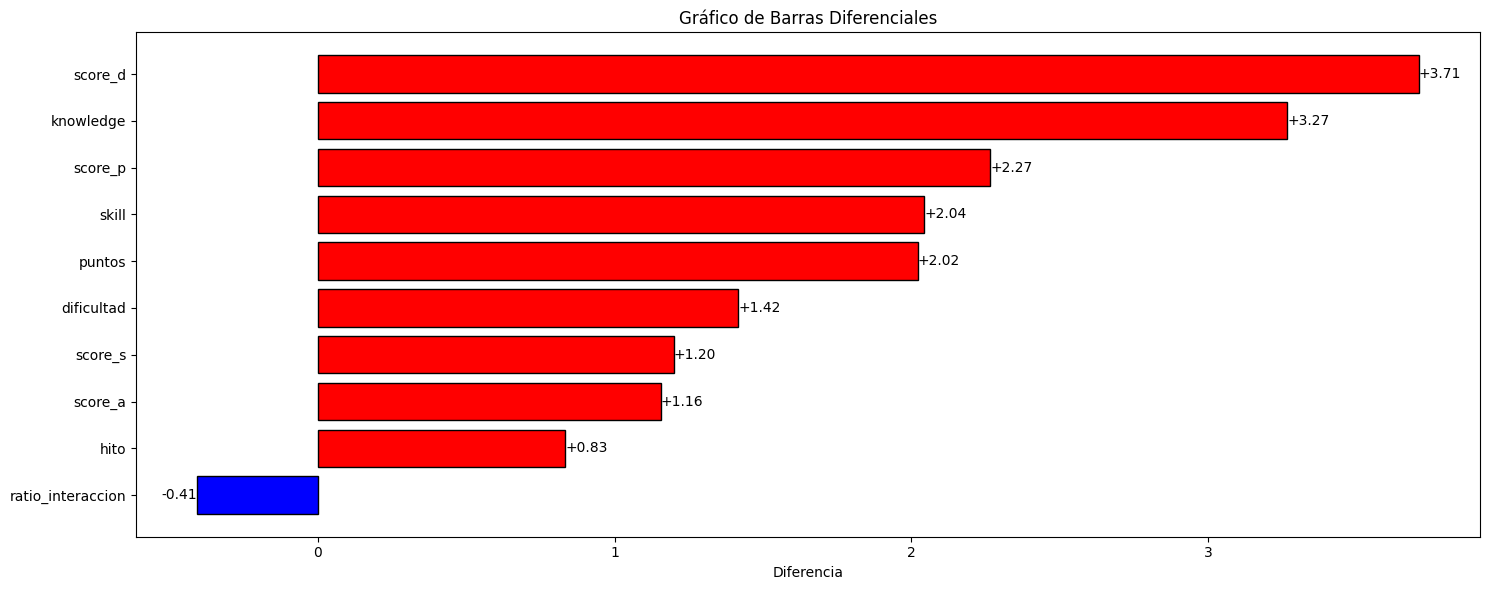

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
variables = df_diferencia.columns.to_list()
diferencias = valores_diferencia

# Ordenar las variables y diferencias por magnitud
orden = np.argsort(diferencias)
variables_ordenadas = np.array(variables)[orden]
diferencias_ordenadas = np.array(diferencias)[orden]

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(15, 6))

# Colores según el signo de la diferencia
colores = ['red' if val > 0 else 'blue' for val in diferencias_ordenadas]

# Crear las barras horizontales
y_pos = np.arange(len(variables))
ax.barh(y_pos, diferencias_ordenadas, color=colores, edgecolor='black')

# Añadir etiquetas
ax.set_yticks(y_pos)
ax.set_yticklabels(variables_ordenadas)
ax.set_xlabel('Diferencia')
ax.set_title('Gráfico de Barras Diferenciales')

# Añadir los valores al final de las barras
for i, val in enumerate(diferencias_ordenadas):
    ax.text(val, i, f'{val:+.2f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()


In [81]:
pd.DataFrame(results6)

,test_rmse,test_mae,fit_time,test_time
0,2.822007,0.111463,0.024746,0.151145
1,2.797158,0.110481,0.026815,0.161607
2,0.000000,0.000000,0.025262,0.207538
3,5.635083,0.157444,0.025896,0.154075
4,1.914984,0.053505,0.025683,0.158800


In [82]:
metricas6

(0.9687651331719129, 0.6721275749713039, 1.0)